# Three-Asset Portfolio Allocation with Reinforcement Learning

## Educational Overview

This notebook extends our asset allocation framework to handle **three assets simultaneously**, representing a more realistic and challenging portfolio management scenario.

### Why Three Assets Matter:

**Increased Complexity:**
- **Combinatorial explosion**: More possible allocation combinations
- **Correlation dynamics**: Three-way asset relationships are more complex
- **Constraint management**: Allocations must still sum to 100%
- **Diversification benefits**: True portfolio diversification requires multiple assets

**Real-World Relevance:**
- **Multi-asset portfolios**: Stocks, bonds, commodities, currencies
- **Risk parity**: Equal risk contribution across asset classes
- **Factor investing**: Exposure to different risk factors
- **Alternative investments**: Including hedge funds, real estate, etc.

### Assets in This Example:

**1. S&P 500 (.SPX)**: 
- **Equity exposure**: US large-cap stocks
- **Growth potential**: Long-term appreciation
- **Cyclical behavior**: Economic sensitivity

**2. VIX (.VIX)**:
- **Volatility exposure**: Market fear/uncertainty
- **Crisis hedge**: Often rises during market stress
- **Mean reverting**: Returns to long-term average

**3. Gold (XAU=)**:
- **Inflation hedge**: Preserves purchasing power
- **Safe haven**: Flight-to-quality during crises
- **Currency alternative**: Dollar weakness hedge

### RL Challenges with Three Assets:

1. **Action Space Complexity**: Two degrees of freedom (third is determined by constraint)
2. **State Space Expansion**: More market variables to track
3. **Correlation Learning**: Understanding three-way relationships
4. **Optimization Difficulty**: Finding optimal allocations becomes harder

### Learning Objectives:
- How to handle **multi-asset allocation** in RL
- How to compare **RL strategies** vs **equal-weight benchmarks**
- How to analyze **Sharpe ratios** across asset classes
- How to evaluate **portfolio performance** in challenging markets

This represents a significant step toward professional-grade portfolio management using AI.

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Reinforcement Learning for Finance

**Chapter 08 &mdash; Dynamic Asset Allocation (Three Asset Case)**

&copy; Dr. Yves J. Hilpisch

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

In [1]:
%run assetallocation.py

In [2]:
days = 2 * 252

In [3]:
random.seed(100)

In [4]:
# 1 = X, 2 = Y, 3 = Z
investing = Investing('.SPX', '.VIX', 'XAU=', steps=days)

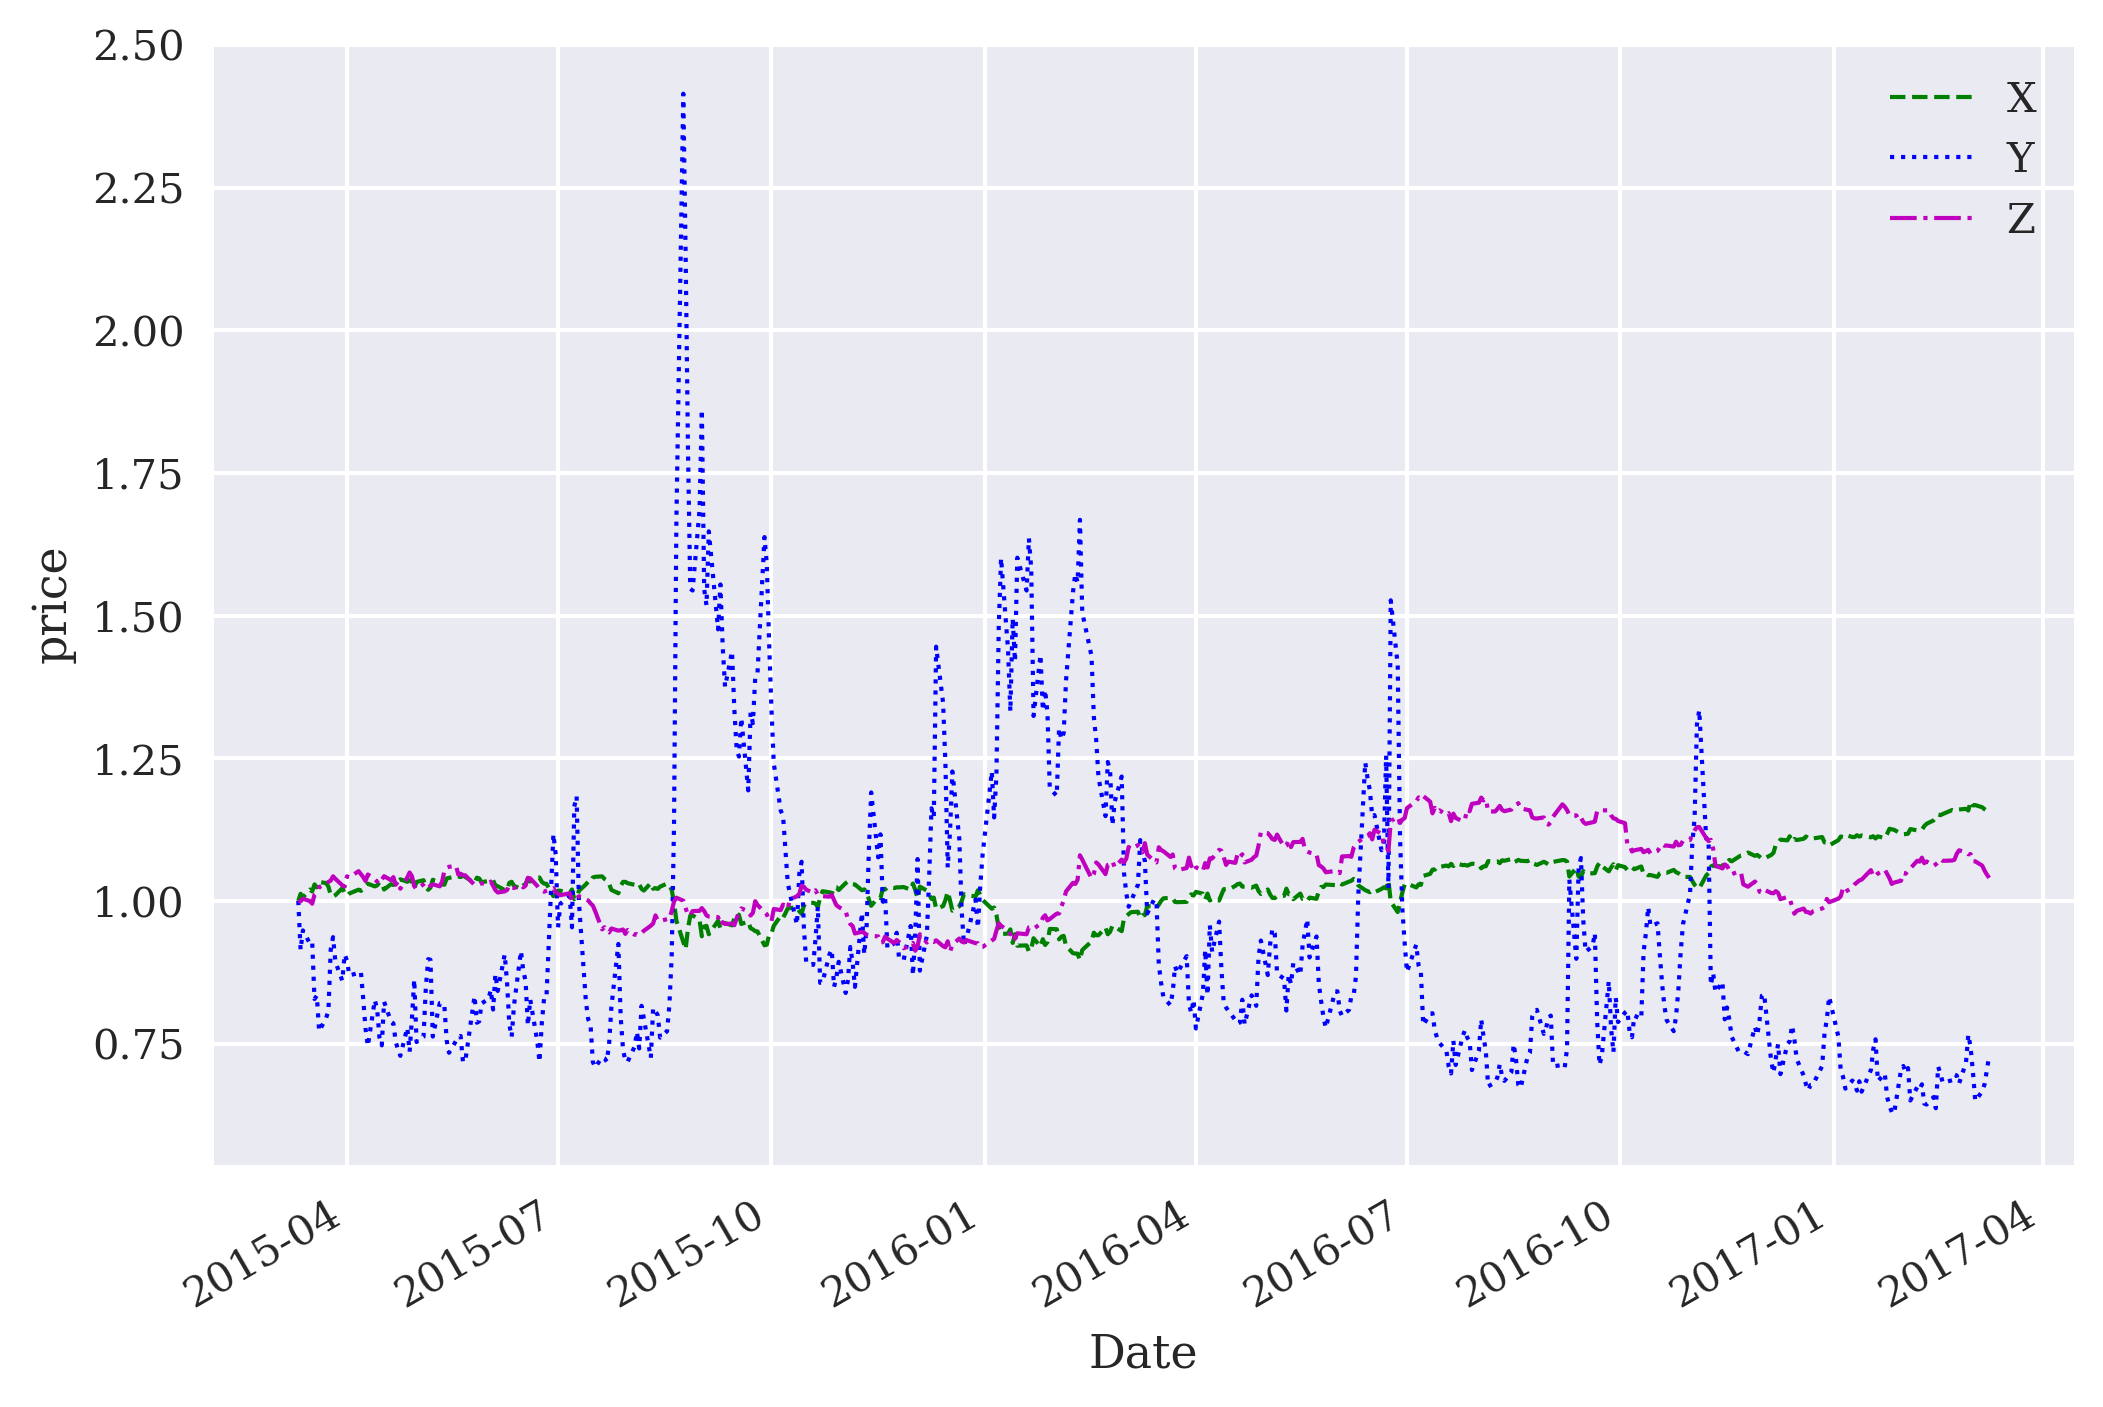

In [5]:
investing.data.plot(lw=1, style=['g--', 'b:', 'm-.'])
plt.ylabel('price');

In [6]:
random.seed(100)
np.random.seed(100)
tf.random.set_seed(100)

## Training a Three-Asset Allocation Agent

The complexity increases significantly when moving from 2 to 3 assets. Our RL agent must learn to **simultaneously optimize** allocations across three different asset classes with distinct risk-return characteristics.

### Key Training Challenges:

**1. Multi-dimensional Action Space:**
- Agent chooses **two allocation weights** (xt, yt)
- Third weight (zt) is automatically determined: zt = 1 - xt - yt
- Requires sophisticated **continuous action optimization**

**2. Complex State Representation:**
- **6-dimensional state space**: Current prices, allocations, and relationships
- Agent must track **three-way correlations** and interactions
- More data needed for **effective learning**

**3. Portfolio Constraint Management:**
- **Budget constraint**: xt + yt + zt = 1 (always fully invested)
- **Non-negativity**: No short selling (all weights â‰¥ 0)
- **Boundary handling**: Action space is constrained to valid allocations

**4. Enhanced Reward Engineering:**
- **Sharpe ratio optimization**: Risk-adjusted returns across three assets
- **Diversification benefits**: Rewards for spreading risk
- **Transaction cost penalties**: Discourage excessive rebalancing

### Expected Learning Outcomes:
- **Dynamic rebalancing**: Adjusts to changing market conditions
- **Risk diversification**: Exploits correlation breakdowns
- **Crisis adaptation**: Defensive positioning during market stress
- **Opportunity capture**: Aggressive positioning in favorable conditions

The agent learns by experiencing thousands of three-asset allocation decisions across varying market regimes.

In [7]:
agent = InvestingAgent('3AC', feature=None, n_features=6,
                     env=investing, hu=128, lr=0.00025)

In [8]:
episodes = 64

In [9]:
%time agent.learn(episodes)

episode=  64 | treward=  2.201 | max=  7.745
CPU times: user 1min 19s, sys: 11.7 s, total: 1min 31s
Wall time: 3min 22s


In [10]:
agent.epsilon

0.8519730927255319

In [11]:
agent.env.portfolios = pd.DataFrame()

In [12]:
%time agent.test(10)

episode=10 | total reward=8.24
CPU times: user 59.6 s, sys: 9.92 s, total: 1min 9s
Wall time: 1min 14s


In [13]:
agent.env.portfolios.groupby('e')[
    ['xt', 'yt', 'zt']].mean().mean()

xt    0.572418
yt    0.341007
zt    0.086576
dtype: float64

In [14]:
agent.env.portfolios.groupby('e')[
    ['Xt', 'Yt', 'Zt', 'pv']].last().mean()

Xt    1.184271
Yt    1.303997
Zt    1.219622
pv    2.927294
dtype: float64

In [15]:
def get_r(n):
    r = agent.env.portfolios[
        agent.env.portfolios['e'] == n
        ].set_index('date')
    return r

In [16]:
n = min(agent.env.portfolios['e']) + 1
n

66

In [17]:
r = get_r(n)

In [18]:
r[['xt', 'yt', 'zt']].mean()

xt    0.518429
yt    0.375992
zt    0.105579
dtype: float64

In [19]:
r[['xt', 'yt', 'zt']].std()

xt    0.089908
yt    0.127021
zt    0.147788
dtype: float64

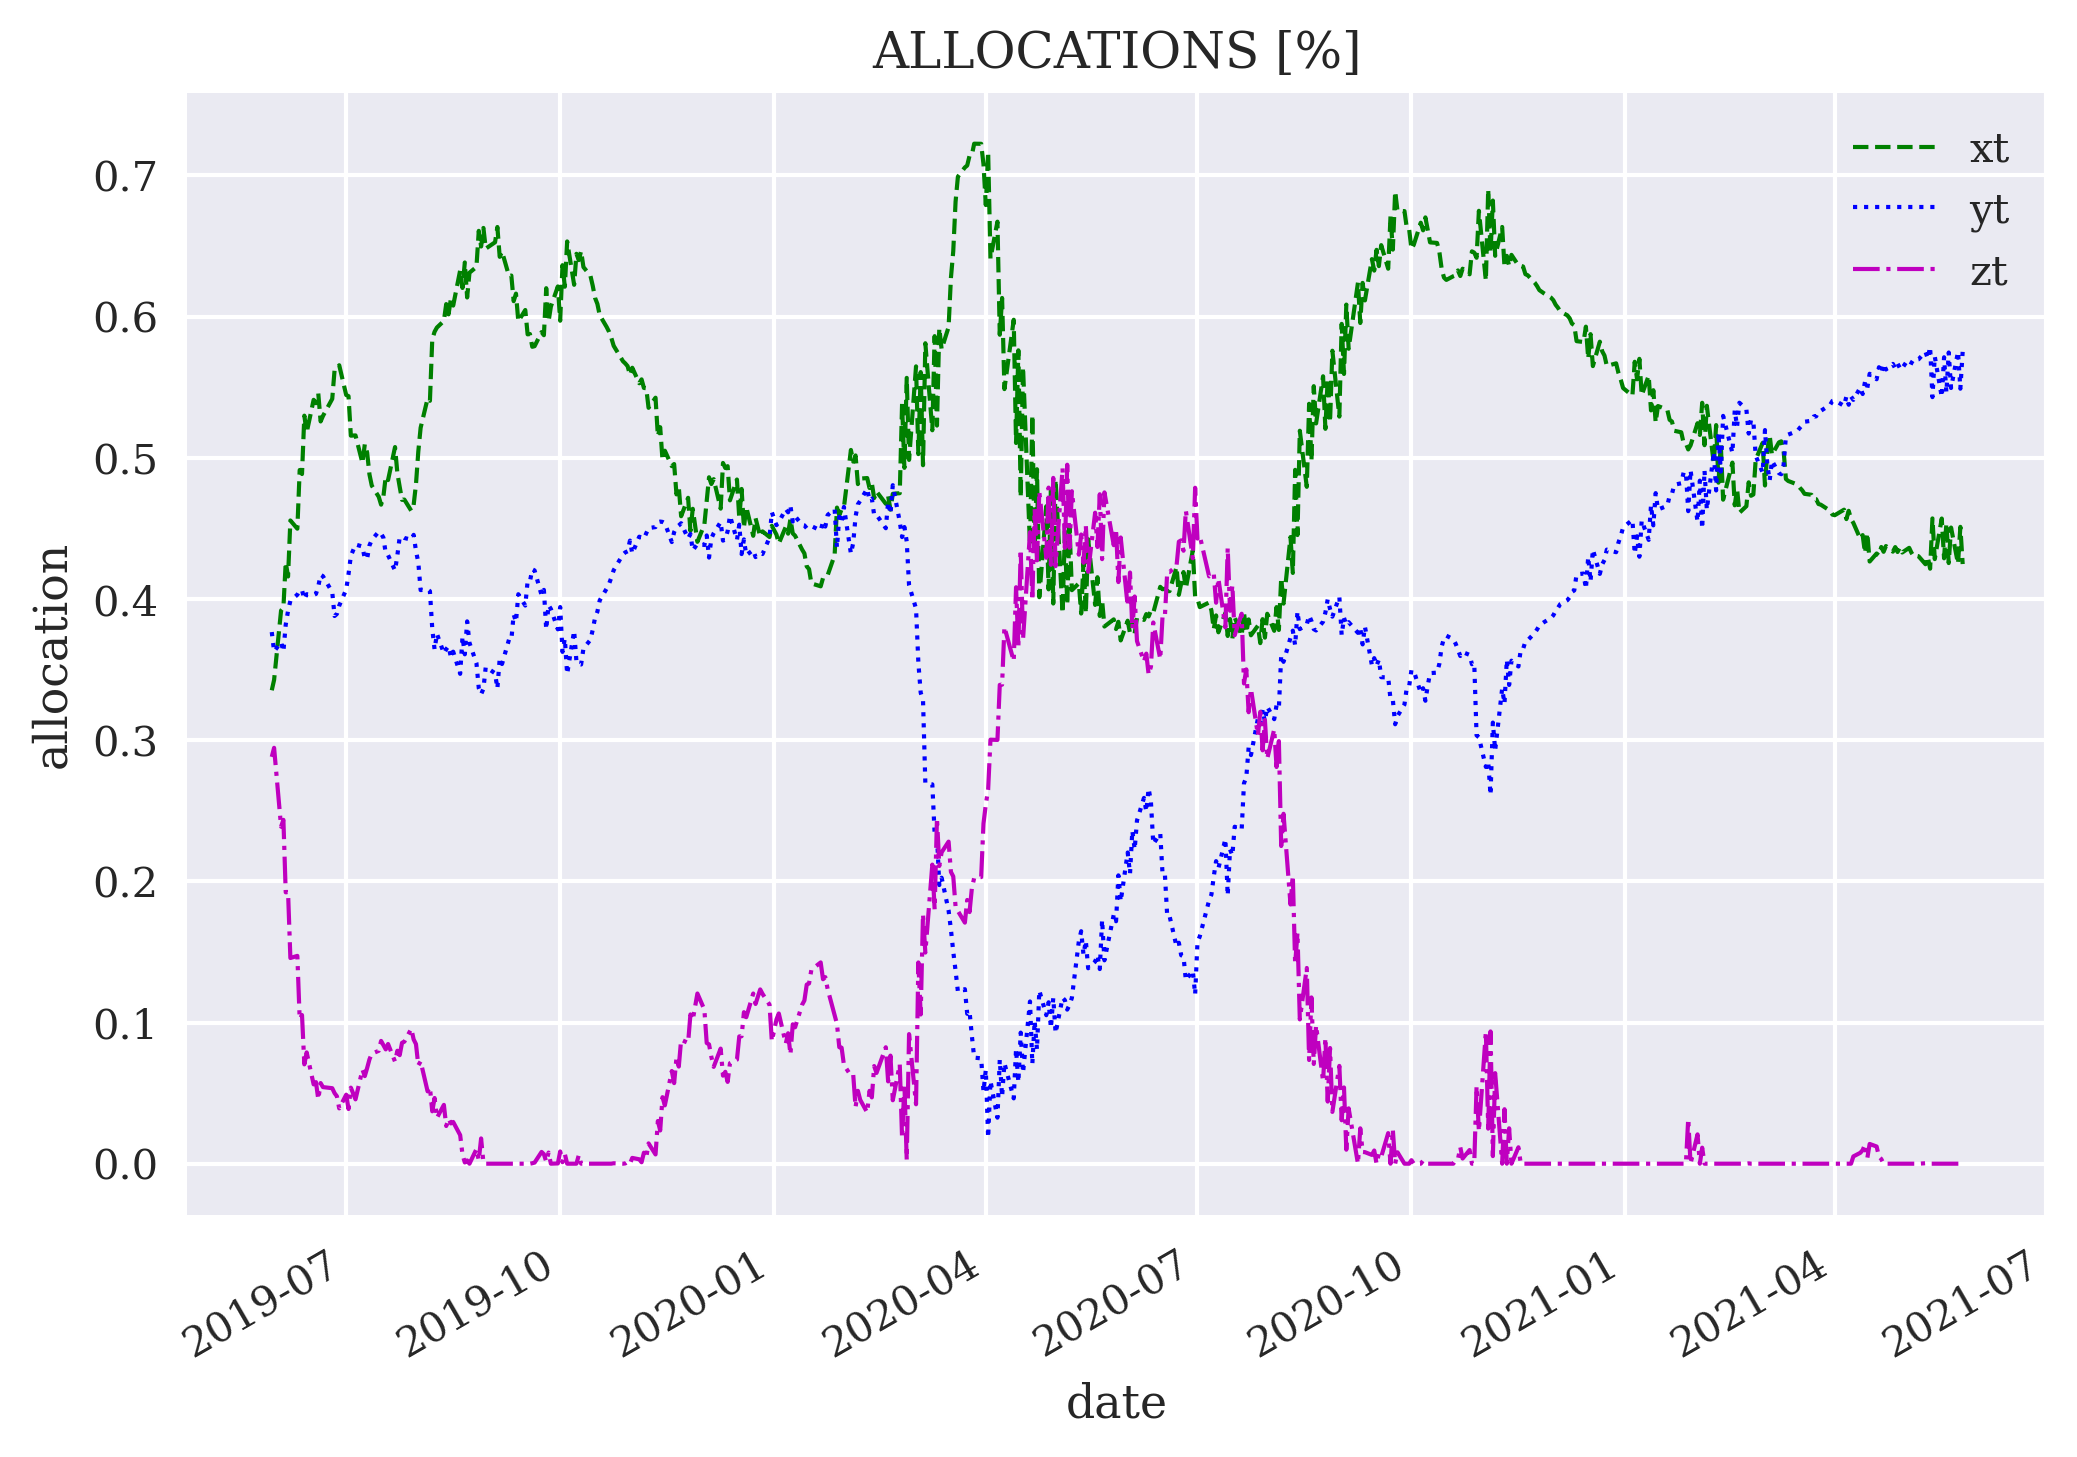

In [20]:
r[['xt', 'yt', 'zt']].plot(
    title='ALLOCATIONS [%]',
    style=['g--', 'b:', 'm-.'],
    lw=1, grid=True)
plt.ylabel('allocation');

In [21]:
cols = ['Xt', 'Yt', 'Zt', 'pv']

In [22]:
sub = r[cols]

In [23]:
rets = sub.iloc[-1] / sub.iloc[0] - 1
rets

Xt    0.504887
Yt    0.052514
Zt    0.484728
pv    2.670451
dtype: float64

In [24]:
stds = sub.pct_change().std() * math.sqrt(252)
stds

Xt    0.261492
Yt    1.475499
Zt    0.167226
pv    0.529418
dtype: float64

In [25]:
rets / stds

Xt    1.930792
Yt    0.035591
Zt    2.898632
pv    5.044123
dtype: float64

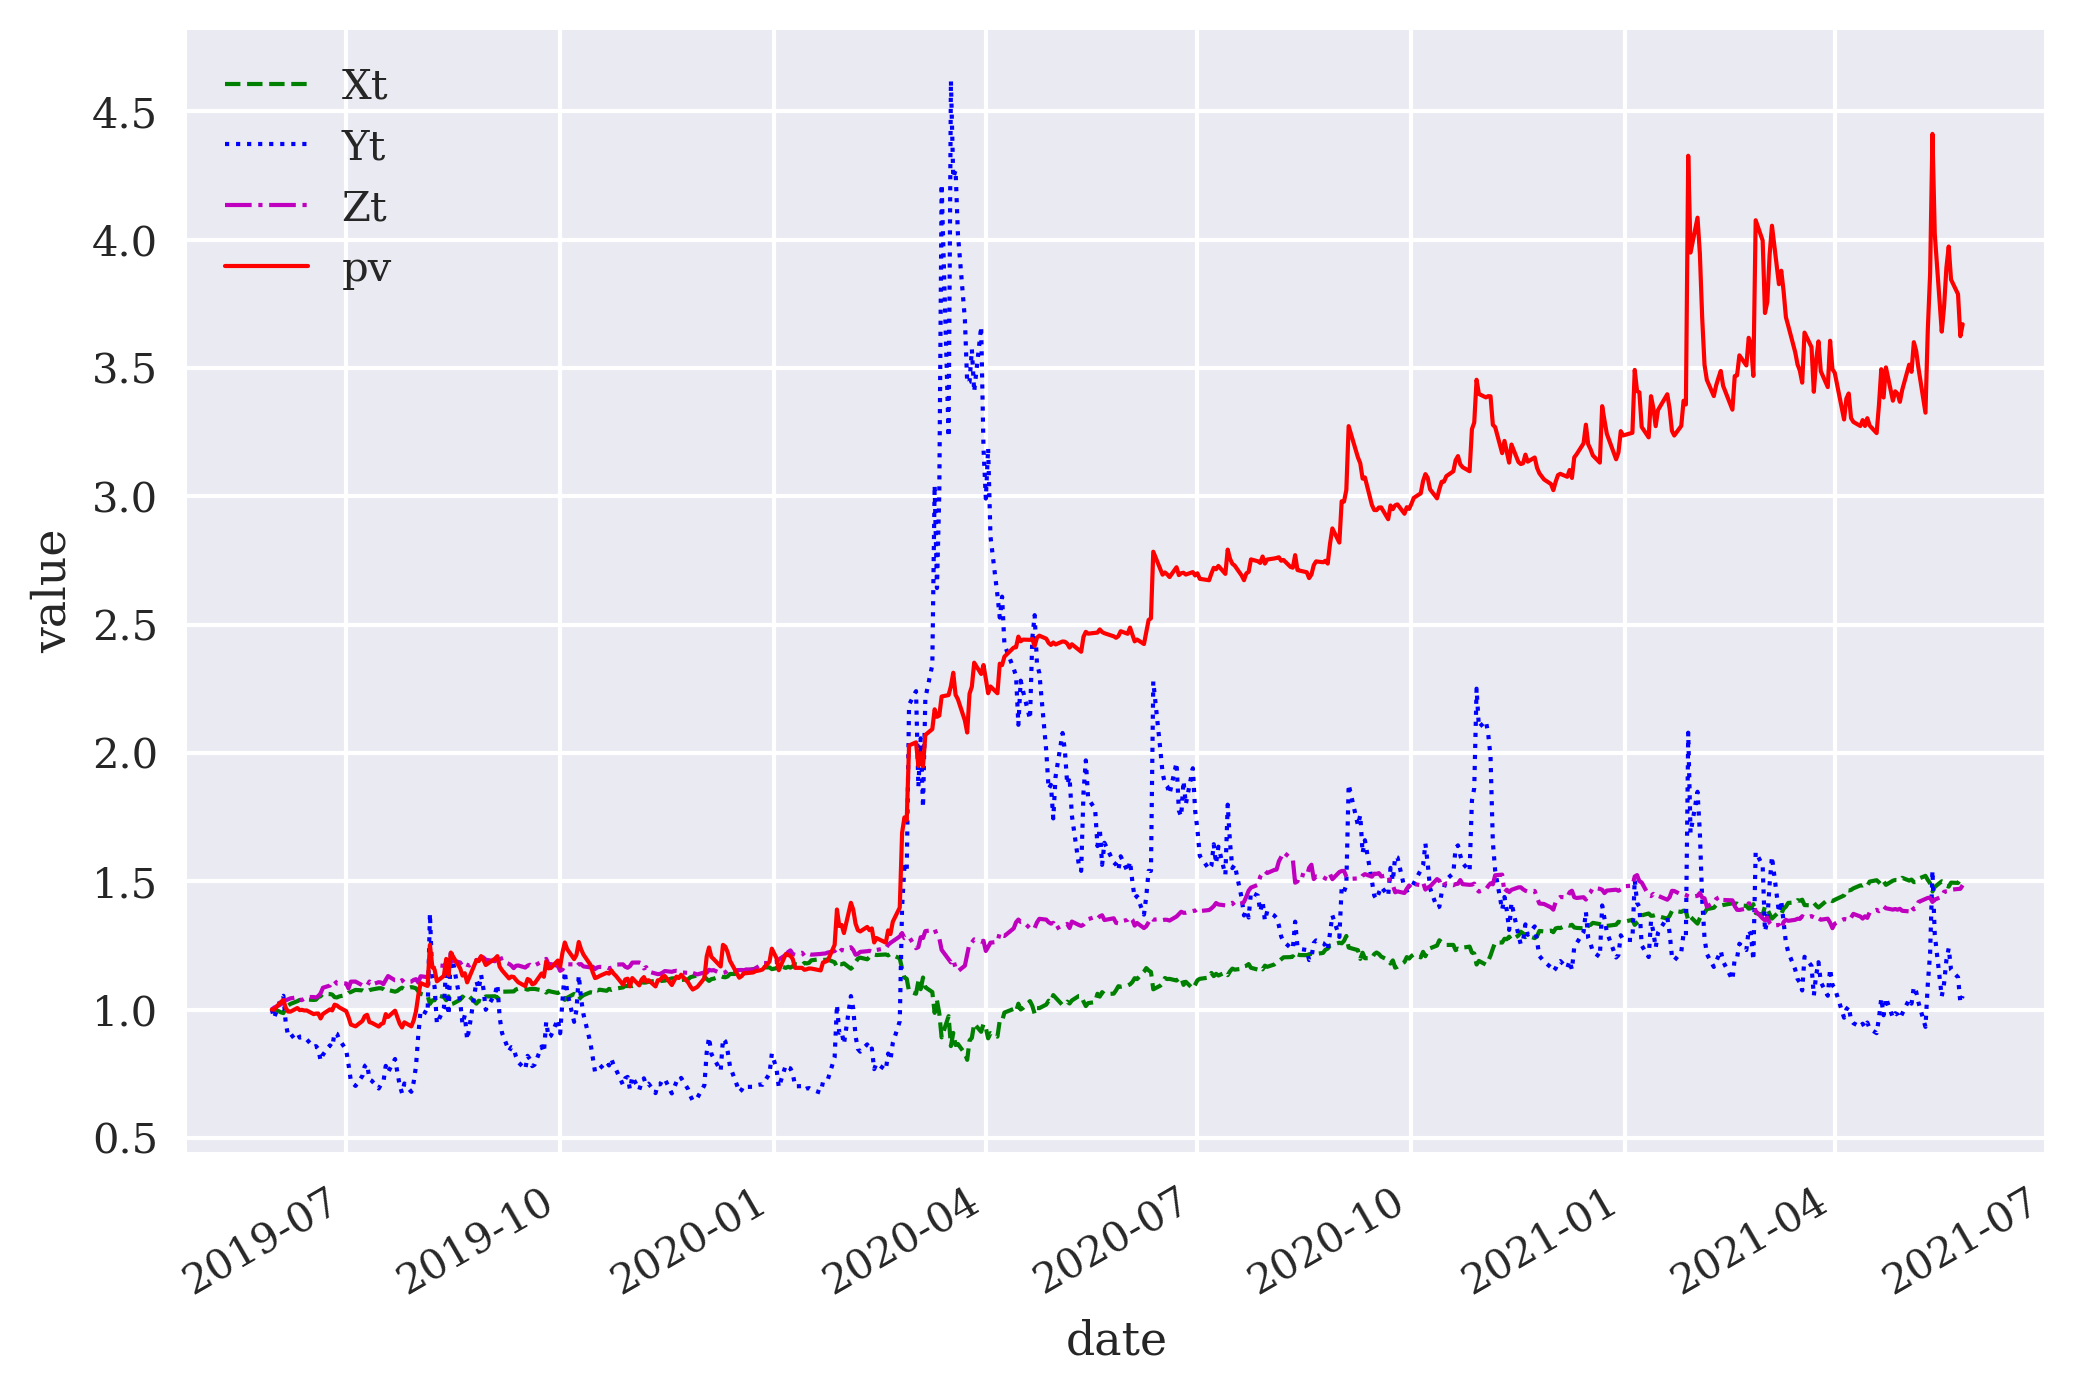

In [26]:
sub.plot(style=['g--', 'b:', 'm-.', 'r-'], lw=1)
plt.ylabel('value');


In [27]:
sharpe = pd.DataFrame()

In [28]:
def calculate_sr():
    for n in set(investing.portfolios['e']):
        r = get_r(n)
        sub = r[cols]
        rets = sub.iloc[-1] / sub.iloc[0] - 1
        stds = sub.pct_change().std() * math.sqrt(252)
        sharpe[n] = rets / stds

In [29]:
calculate_sr()

In [30]:
sharpe.round(2)

65    66    67    68    69    70    71    72    73    74
Xt  1.69  1.93 -0.01  0.41  0.16  1.34  0.30  1.31  1.52  0.53
Yt  0.29  0.04 -0.13 -0.05 -0.14  0.31  0.76 -0.11  0.21  0.80
Zt  2.78  2.90  0.86 -0.21  0.51  0.71  2.13  1.12  1.19  3.24
pv  6.55  5.04  2.08  1.11  2.32  3.67  7.09  2.80  3.76  7.84

In [31]:
sharpe.mean(axis=1)

Xt    0.917560
Yt    0.197753
Zt    1.523657
pv    4.225037
dtype: float64

In [32]:
((sharpe.loc['pv'] > sharpe.loc['Xt']) &
 (sharpe.loc['pv'] > sharpe.loc['Yt']) &
 (sharpe.loc['pv'] > sharpe.loc['Zt'])).value_counts()

True    10
Name: count, dtype: int64

## Equally Weighted Portfolio

## Performance Analysis: RL vs Benchmarks

Now we analyze our trained agent's performance by comparing it to traditional benchmarks and examining key metrics.

### Key Performance Metrics:

**1. Sharpe Ratio Analysis:**
- **Risk-adjusted returns**: Return per unit of risk taken
- **Cross-asset comparison**: How does each asset perform individually?
- **Portfolio enhancement**: Does RL beat individual assets?

**2. Allocation Pattern Analysis:**
- **Average allocations**: Which assets does the agent prefer?
- **Allocation volatility**: How frequently does it rebalance?
- **Regime dependency**: How do allocations change with market conditions?

**3. Outperformance Statistics:**
- **Win rate**: Frequency of beating all individual assets
- **Consistency**: Performance across different market periods
- **Risk management**: Downside protection capabilities

### The Equal-Weight Benchmark Challenge:

**Equal-weight strategy** (33.33% to each asset) represents a simple, naive diversification approach:
- **No intelligence**: Fixed allocations regardless of market conditions
- **Rebalancing requirement**: Periodic rebalancing to maintain weights
- **Diversification benefit**: Reduces concentration risk
- **Traditional baseline**: Common institutional benchmark

### Why This Comparison Matters:
- **Skill measurement**: Does RL add value over simple diversification?
- **Transaction costs**: Equal-weight requires less frequent rebalancing
- **Robustness**: Can RL consistently outperform across market cycles?
- **Practical application**: Is the complexity worth the potential gains?

This analysis reveals whether artificial intelligence can truly enhance portfolio management beyond traditional approaches.

In [33]:
agent.opt_action = lambda state: np.ones(3) / 3

In [34]:
agent.env.portfolios = pd.DataFrame()

In [35]:
%time agent.test(10)

episode=10 | total reward=4.75
CPU times: user 2.87 s, sys: 94.8 ms, total: 2.96 s
Wall time: 19.2 s


In [36]:
sharpe = pd.DataFrame()

In [37]:
calculate_sr()

In [38]:
sharpe.round(2)

75    76    77    78    79    80    81    82    83    84
Xt  1.35  0.41  2.73  1.10  0.38  3.46  1.35  0.81  0.61  1.84
Yt  0.06  0.20 -0.08  0.62 -0.02 -0.18  0.06 -0.05  0.75 -0.16
Zt  1.23 -0.44  0.37  1.52 -0.16 -0.87  1.23 -0.72  4.86  1.30
pv  1.67  1.52  1.32  2.52  1.25  0.96  1.67  1.27  3.77  1.76

In [39]:
sharpe.mean(axis=1)

Xt    1.402960
Yt    0.121449
Zt    0.830933
pv    1.769955
dtype: float64

In [40]:
((sharpe.loc['pv'] > sharpe.loc['Xt']) &
 (sharpe.loc['pv'] > sharpe.loc['Yt']) &
 (sharpe.loc['pv'] > sharpe.loc['Zt'])).value_counts()

True     6
False    4
Name: count, dtype: int64

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>